In [2]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib

## 1.1 Simulation

1. pendulum_rhs(zt, dzt, coefficients, terms) to compute the scalar product Θ(z, z˙) · Ξ
between the function terms and the coefcients at the given time points (zt, dzt). Note
that the function should be vectorized, so that (zt, dzt) can be vectors of time points.

In [3]:
def fill_theta_matrix(functions, data):
    assert type(data) == type(functions) == np.ndarray
    theta = np.zeros((data.shape[0], functions.shape[0]))
    for i in range(functions.shape[0]):
        function = functions[i]
        theta[:, i] = function(data[:, 0], data[:, 1])
    return theta

In [112]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    #selected_terms =   [lambda x: terms[i]*coefficients[i] for i in range(len(terms)) if abs(coefficients[i]) > 1E-12]
    filled_theta_matrix = fill_theta_matrix(terms, np.array([zt, dzt]).T)
    return filled_theta_matrix @ coefficients.T
    

2. pendulum_ode_step(y, t, coefficients, terms) to be used as the func parameter to
scipy.integrate.odeint.

In [113]:
def pendulum_ode_step(y, t, coefficients, terms):
    zt, dzt = y
    return [dzt, *pendulum_rhs(np.array([zt]), np.array([dzt]), coefficients, terms)[0]]

3. simulate_pendulum(z0, dz0, coefficients, terms, T, dt) that uses odeint to simulate the pendulum with the initial conditions z0, z˙0 for T steps with step size ∆t.

In [6]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, dt * T, T)
    sol = odeint(pendulum_ode_step, np.array([z0, dz0]),t, args=(coefficients, terms))
    return sol, t

In [7]:
coeff = np.array([[-5, 0, 0, -0.25]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
sol, t = simulate_pendulum(np.pi-0.1, 0, coeff,terms, 100, 0.1)

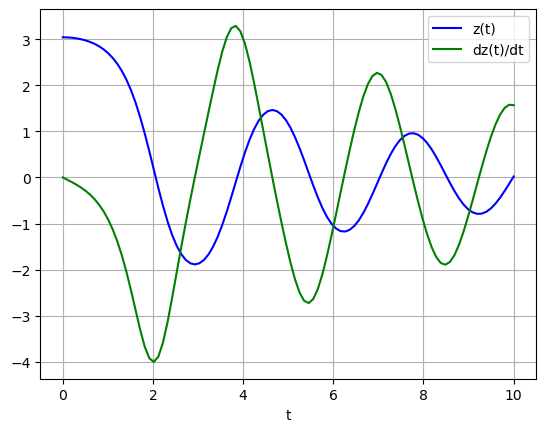

In [8]:
plt.plot(t, sol[:, 0], 'b', label='z(t)')
plt.plot(t, sol[:, 1], 'g', label='dz(t)/dt')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

This is consistent with the example results from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
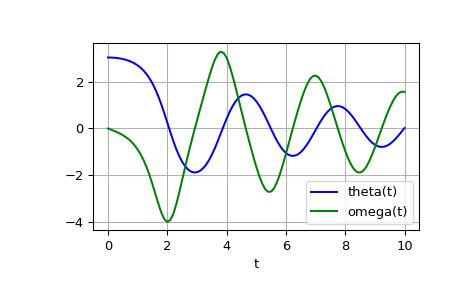

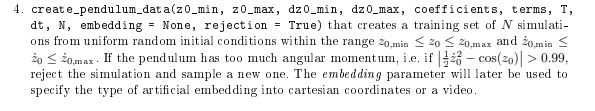

In [32]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding = None, rejection = True):
    dom_z = np.linspace(z0_min, z0_max, 1000)
    dom_dz = np.linspace(dz0_min, dz0_max, 1000)
    initial_conditions = []
    for i in range(N):
        generated = False
        index = 0
        while not generated:
            z_0 = np.random.choice(dom_z)
            possible_dz_indices = np.where(np.abs(0.5*dom_dz**2 - np.cos(z_0)) <= 0.99)[0]
            if len(possible_dz_indices) > 0 or index == 25:
                generated = True
            index += 1
        dz_0 = np.random.choice(dom_dz[possible_dz_indices])

        
        initial_conditions.append(np.array([z_0, dz_0]))
    initial_conditions = np.array(initial_conditions)

    ts = []
    for z_0, dz_0 in initial_conditions:
        sol, t = simulate_pendulum(z_0, dz_0, coefficients, terms, T, dt)
        ddz = pendulum_rhs(sol[:, 0], sol[:, 1], coefficients, terms)
        ts.append(np.array([sol[:, 0], sol[:, 1], ddz[:, 0]]))
    return ts
        
        
                              

In [66]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = create_pendulum_data(-1, 1, -1, 1, coeff, terms, 500, 0.02, 2, embedding = None, rejection = True)
coeff = np.array([[-1, 0, 0, -0.05]])
dampened_data = create_pendulum_data(-1, 1, -1, 1, coeff, terms, 500, 0.02, 2, embedding = None, rejection = True)

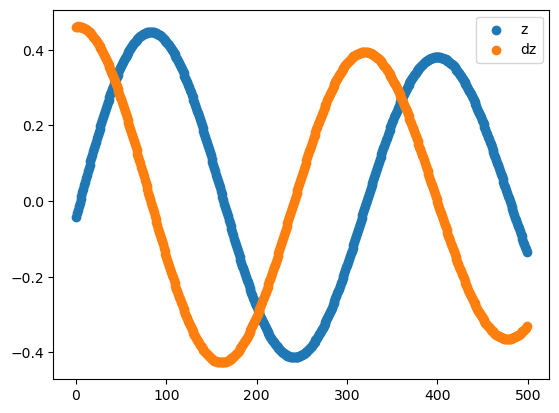

In [67]:
plt.scatter(range(500), dampened_data[1][0], label="z")
plt.scatter(range(500), dampened_data[1][1], label="dz")
plt.legend()

## 2.1 Cartesian Embedding

In [114]:
def embed_cartesian(z, dz, ddz):
    x = np.array([np.sin(z), -np.cos(z)])
    dx =  np.array([np.cos(z) * dz, np.sin(z)*dz])
    ddx =  np.array([-np.sin(z) * dz**2 + np.cos(z)*ddz, np.cos(z)+dz**2+np.sin(z)*ddz])
    return np.array([x,dx,ddx])

## 1.1

In [69]:
def create_phase_plot(data):
    fig, axs = plt.subplots(len(data), 3, constrained_layout=True)
    fig.suptitle("Phase portrait", fontsize="x-large")
    for i in range(len(data)):
        simulation = data[i]
        coords = embed_cartesian(*simulation)
        axs[i, 0].scatter(coords[0, 0, :], coords[1, 0, :])
        axs[i, 0].set_xlabel("Position in x")
        axs[i, 0].set_ylabel("Velocity")
        axs[i, 1].scatter(coords[0, 1, :], coords[1, 1, :])
        axs[i, 1].set_xlabel("Position in y")
        axs[i, 1].set_ylabel("Velocity")
        axs[i, 2].scatter(simulation[0, :], simulation[1, :])
        axs[i, 2].set_xlabel("z")
        axs[i, 2].set_ylabel("dz")
    plt.show()

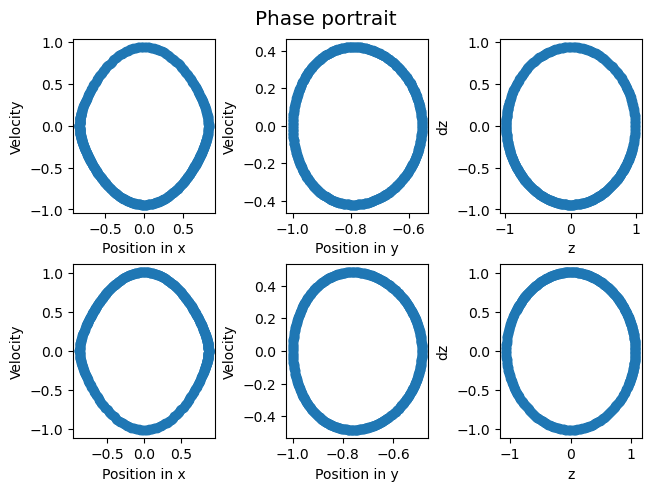

In [70]:
create_phase_plot(data)

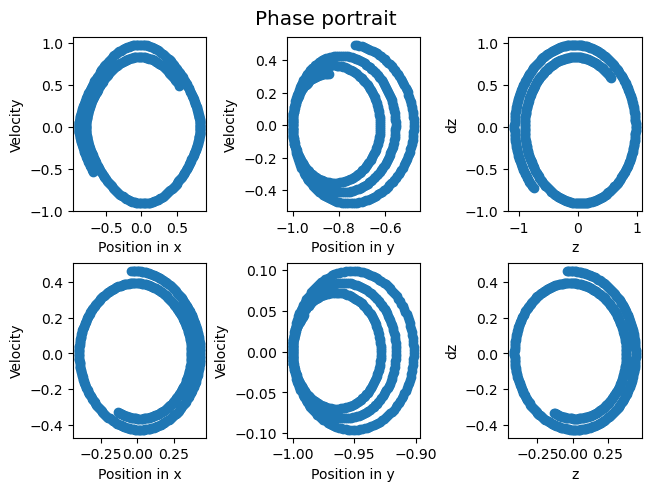

In [72]:
create_phase_plot(dampened_data)

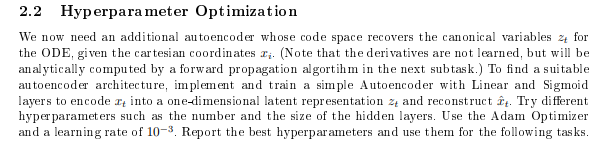

In [156]:
class VariableAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, layers, activation="ReLU"):
        assert activation =="ReLU" or activation == "sigmoid"
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers
        
        self.encoder = [] 
        self.decoder = []
        self.encoder.append(nn.Linear(self.input_size, self.hidden_size))
        self.decoder.append(nn.Linear(1, self.hidden_size))
        
        
        for layer in range(self.layers - 1):
            self.encoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.decoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            
            if activation == "reLU":
                self.encoder.append(nn.ReLU())
                self.decoder.append(nn.ReLU())
            
            if activation == "sigmoid":
                self.encoder.append(nn.Sigmoid())
                self.decoder.append(nn.Sigmoid())
                
        self.encoder.append(nn.Linear(self.hidden_size, 1))
        self.decoder.append(nn.Linear(self.hidden_size, self.input_size))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))
        

    

In [157]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = np.array(create_pendulum_data(-1, 1, -1, 1, coeff, terms, 500, 0.02, 5, embedding = None, rejection = True))
data = np.array([embed_cartesian(*simulation)[0] for simulation in data])
data.shape

(5, 2, 500)

In [161]:
def train_auto_encoder(autoencoder, train_data, num_epochs, lr=0.001):
    X = torch.FloatTensor(train_data)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_list=[]
    state_dicts = {}#Storage parameters
    for epoch in range(num_epochs):
        for data in X:
            inputs, _ = data

            # Forward
            _,outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        loss_list.append(loss.item())

    return loss_list


model = VariableAutoencoder(2, 5,3)
train_auto_encoder(model, data, 20)



# Plot loss
plt.plot(range(num_epochs), loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'DataLoader' is not defined